
# DY at leading order, SM and NP contributions 
This notebook implements the **LO Drell–Yan dilepton invariant-mass distribution** using the **form-factor decomposition**
$\gamma/Z$ + **contact interactions** used in the paper, and computes:
- $d\sigma(pp\to \ell^+\ell^-)/dm_{\ell\ell}$ at $\sqrt{s}=13$ TeV
- the LFU ratio $R_{\mu\mu/ee}(m_{\ell\ell})$, if it becomes useful later in the project

It follows the paper’s notation closely:
- Form factors $F_{q\ell}(s)$ with SM poles + EFT contact term (paper Eq. (3))
- Parton luminosities $L_{q\bar q}(\tau,\mu_F)$ (paper App. A)
- Hadronic spectrum from luminosity convolution (paper Eq. (4)/(8))


In [2]:

import numpy as np
import math
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Dict, Callable, Tuple, Optional

from scipy import integrate



## 1. SM constants and couplings (paper Eq. (3))
We use:
- $v=246$ GeV
- $m_Z, \Gamma_Z$
- $\alpha_{\rm em}$ and $\sin^2\theta_W$

The paper defines the $Z$ coupling as
$$
g_Z^f = \frac{2m_Z}{v}\left(T_3^f - Q_f \sin^2\theta_W\right).
$$


In [30]:

# --- electroweak constants ---
v = 246.0  # GeV
mZ = 91.1876  # GeV
GammaZ = 2.4952  # GeV

# Typical alpha_em used in LO DY work; adjust if you want a different scheme.
alpha_em = 1/127.95
e2 = 4*np.pi*alpha_em
e = math.sqrt(e2)

# Weak mixing angle (default value; you can swap to your preferred scheme)
sin2_thetaW = 0.23126

def gZ(T3, Q):
    """Z coupling to fermion with T3 and Q."""
    return (2*mZ/v) * (T3 - Q*sin2_thetaW)

# charges and T3 values
Q_u, T3_uL, T3_uR =  2/3,  1/2, 0.0
Q_d, T3_dL, T3_dR = -1/3, -1/2, 0.0
Q_e, T3_lL, T3_lR = -1.0, -1/2, 0.0

gZuL = gZ(T3_uL, Q_u)
gZuR = gZ(T3_uR, Q_u)
gZdL = gZ(T3_dL, Q_d)
gZdR = gZ(T3_dR, Q_d)

gZlL = gZ(T3_lL, Q_e)
gZlR = gZ(T3_lR, Q_e)

(gZuL, gZuR, gZdL, gZdR, gZlL, gZlR)


(0.2563829573116531,
 -0.11429834350135502,
 -0.3135321290623307,
 0.05714917175067751,
 -0.1992337855609756,
 0.17144751525203253)

In [100]:
# Translate Lambda to epsilon
def eps_from_Lambda(Lambda_TeV, sign=+1.0):
    """
    Convert a scale Lambda in TeV to a dimensionless epsilon parameter.
    """
    Lam = Lambda_TeV*1e3  # GeV
    return sign * (v**2)/(Lam**2)

# Example usage
eps_from_Lambda(30.0, sign=+1.0)

6.724e-05


## 2. Form factors $F_{q\ell}(s)$ including contact terms (paper Eq. (3))
We implement (for each quark chirality $q_{L/R}$ and lepton chirality $\ell_{L/R}$):
$$
F_{q\ell}(s)= \frac{e^2 Q_q Q_\ell}{s}
+ \frac{g_Z^q g_Z^\ell}{s-m_Z^2+i m_Z\Gamma_Z}
+ \frac{\varepsilon_{q\ell}}{v^2}.
$$

The contact term $\varepsilon_{q\ell}$ is related to SMEFT coefficients by $\varepsilon=v^2 c/\Lambda^2$.


In [107]:

def F_form_factor(s, Qq, Ql, gZq, gZl, eps=0.0):
    """
    Factorised form factor F_{qℓ}(s) in the paper's parametrisation.
    """
    photon = e2 * Qq * Ql / s
    #zprop = (gZq * gZl) / (s - mZ**2 + 1j*mZ*GammaZ)
    zprop = (gZq * gZl) / (s - mZ**2)
    contact = eps / v**2
    return photon + zprop + contact


In [108]:
# Example: three form factors and their modulus-squared
s_example = 1000.0**2  # GeV^2

F1 = F_form_factor(s_example, Q_u, Q_e, gZuL, gZlL, eps=0.0)
F2 = F_form_factor(s_example, Q_u, Q_e, gZuL, gZlL, eps=eps_from_Lambda(30.0, sign=+1.0))
F3 = F_form_factor(s_example, Q_u, Q_e, gZuL, gZlL, eps=eps_from_Lambda(30.0, sign=-1.0))

examples = {"F1 (SM photon+Z)": F1, 
            "F2 (+eps, 30 TeV)": F2, 
            "F3 (-eps, 30 TeV)": F3}

for name, val in examples.items():
    print(name, "=", val)
    print("|{}|^2 =".format(name), abs(val)**2)
    print()

F1 (SM photon+Z) = -1.1698387236842537e-07
|F1 (SM photon+Z)|^2 = 1.3685226394312036e-14

F2 (+eps, 30 TeV) = -1.1587276125731425e-07
|F2 (+eps, 30 TeV)|^2 = 1.3426496801394546e-14

F3 (-eps, 30 TeV) = -1.1809498347953648e-07
|F3 (-eps, 30 TeV)|^2 = 1.3946425123031995e-14




## 3. Partonic cross section at LO (paper App. A)
Using paper App. A:
$$
\hat\sigma(s)=\frac{s}{144\pi}\sum_{\text{chiralities}} |F_{q\ell}(s)|^2.
$$
We treat the unpolarised partonic cross section with the chiral sum.


In [122]:
# Translate Lambda to epsilon
def eps_from_Lambda(Lambda_TeV, sign=+1.0):
    """
    Convert a scale Lambda in TeV to a dimensionless epsilon parameter.
    """
    Lam = Lambda_TeV*1e3  # GeV
    return sign * (v**2)/(Lam**2)

# Example usage
eps_from_Lambda(30.0, sign=+1.0)

6.724e-05

In [134]:
# Separate the EFT contributions from SM
def F_SM(s, Qq, Ql, gZq, gZl):
    # photon
    photon = e2 * Qq * Ql / s

    # Z boson
    #zprop = (gZq * gZl) / (s - mZ**2 + 1j*mZ*GammaZ)
    zprop = (gZq * gZl) / (s - mZ**2)
    return photon + zprop

def amp2_eft(Fsm, eps, eft_order="lin"):
    """
    Return |F|^2 in either:
      - 'sm'   : |Fsm|^2
      - 'lin'  : |Fsm|^2 + 2 Re(Fsm * Fci*)
      - 'full' : |Fsm + Fci|^2
    """
    # Contact interaction in the amplitude
    Fci = eps / v**2

    # SM or EFT interactions
    if eft_order == "sm":
        return np.abs(Fsm)**2
    elif eft_order == "lin":
        #return np.abs(Fsm)**2 + 2.0 * np.real(Fsm * np.conj(Fci))
        return Fsm**2 + 2.0 * (Fsm * Fci)
    elif eft_order == "quad":
        return (Fsm + Fci)**2
    else:
        raise ValueError("eft_order must be one of {'sm','lin','quad'}")

def make_sigmahat(Qq, gZqL, gZqR, Ql=Q_e, gZlL=gZlL, gZlR=gZlR,
                  eft_order="lin"):
    def _sigmahat(s, eps_dict):
        # SM pieces (no contact)
        Fsm_qL_lL = F_SM(s, Qq, Ql, gZqL, gZlL)
        Fsm_qL_lR = F_SM(s, Qq, Ql, gZqL, gZlR)
        Fsm_qR_lL = F_SM(s, Qq, Ql, gZqR, gZlL)
        Fsm_qR_lR = F_SM(s, Qq, Ql, gZqR, gZlR)

        # eps per chirality
        eps_qL_lL = eps_dict.get(("qL","lL"), 0.0)
        eps_qL_lR = eps_dict.get(("qL","lR"), 0.0)
        eps_qR_lL = eps_dict.get(("qR","lL"), 0.0)
        eps_qR_lR = eps_dict.get(("qR","lR"), 0.0)

        chiral_sum = (
            amp2_eft(Fsm_qL_lL, eps_qL_lL, eft_order=eft_order) +
            amp2_eft(Fsm_qL_lR, eps_qL_lR, eft_order=eft_order) +
            amp2_eft(Fsm_qR_lL, eps_qR_lL, eft_order=eft_order) +
            amp2_eft(Fsm_qR_lR, eps_qR_lR, eft_order=eft_order)
        )

        return (s/(144*np.pi)) * chiral_sum  # GeV^-2

    return _sigmahat


In [139]:
# Example usage
eps_example = eps_from_Lambda(30.0, sign=-1.0)

sigmahat_example_sm = make_sigmahat(Q_u, gZuL, gZuR, eft_order="sm")
print(sigmahat_example_sm(1000.0**2, {("qL","lL"): eps_example}))  # GeV^-2

sigmahat_example_lin = make_sigmahat(Q_u, gZuL, gZuR, eft_order="lin")
print(sigmahat_example_lin(1000.0**2, {("qL","lL"): eps_example}))  # GeV^-2

sigmahat_example_quad = make_sigmahat(Q_u, gZuL, gZuR, eft_order="quad")
print(sigmahat_example_quad(1000.0**2, {("qL","lL"): eps_example}))  # GeV^-2

5.1294395910560556e-11
5.186904287196384e-11
5.187177186618696e-11


In [141]:
print(F_SM(1000.0**2, Q_u, Q_e, gZuL, gZlL))
print(eps_example / v**2)


-1.1698387236842537e-07
-1.111111111111111e-09


In [113]:

def make_sigmahat(Qq, gZqL, gZqR, Ql=Q_e, gZlL=gZlL, gZlR=gZlR):
    # Returns sigmahat(s, eps_dict) for a specific quark flavour and lepton species.
    """
    Qq, Ql: float, float. Fractional charges.
    gZqL, gZqR: float. Z couplings to left- and right-handed quarks.
    gZlL, gZlR: float. Z couplings to left- and right-handed leptons.
    """
    def _sigmahat(s, eps_dict):
        """
        s: squared partonic center-of-mass energy
        eps_dict: dictionary of additional parameters
        """
        F_qL_lL = F_form_factor(s, Qq, Ql, gZqL, gZlL, eps_dict.get(("qL","lL"), 0.0))
        F_qL_lR = F_form_factor(s, Qq, Ql, gZqL, gZlR, eps_dict.get(("qL","lR"), 0.0))
        F_qR_lL = F_form_factor(s, Qq, Ql, gZqR, gZlL, eps_dict.get(("qR","lL"), 0.0))
        F_qR_lR = F_form_factor(s, Qq, Ql, gZqR, gZlR, eps_dict.get(("qR","lR"), 0.0))

        # Turn off width, so form factor is real
        #chiral_sum = (abs(F_qL_lL)**2 + abs(F_qL_lR)**2 +
                      #abs(F_qR_lL)**2 + abs(F_qR_lR)**2)
        chiral_sum = (F_qL_lL**2 + F_qL_lR**2 +
                      F_qR_lL**2 + F_qR_lR**2)

        # print individual chiralities to check
        #print("Chiralities:")
        #print("|F_qL_lL|^2:", abs(F_qL_lL)**2)
        #print("|F_qL_lR|^2:", abs(F_qL_lR)**2)
        #print("|F_qR_lL|^2:", abs(F_qR_lL)**2)
        #print("|F_qR_lR|^2:", abs(F_qR_lR)**2)

        return (s/(144*np.pi)) * chiral_sum  # GeV^-2
    return _sigmahat

# Example usage
sigmahat_example = make_sigmahat(Q_u, gZuL, gZuR)
sigmahat_example(1000.0**2, {("qL","lL"): 0.01})  # GeV^-2


2.6192044159926007e-11

In [114]:
# More details on eps_dict
eps_dict_example = {
    ("qL", "lL"): 0.01,
    ("qL", "lR"): 0.02,
    ("qR", "lL"): 0.03,
    ("qR", "lR"): 0.04
}

# Accessing values from eps_dict. Return SM if key is not found.
eps_dict_example.get(("qL","lL"), 0.0)

0.01

In [115]:
# Appendix: use of abs()
np.allclose(abs(1+1j), np.sqrt(2))


True


## 4. PDFs and parton luminosities $L_{q\bar q}(\tau)$ (paper App. A)
The luminosity is
$$
L_{q\bar q}(\tau,\mu_F)=\int_\tau^1 \frac{dx}{x} f_q(x,\mu_F) f_{\bar q}(\tau/x,\mu_F).
$$


In [116]:
# --- PDF interface ---
class PDFLike:
    def xfxQ(self, pid: int, x: float, Q: float) -> float:
        raise NotImplementedError

def try_import_lhapdf(pdfset_name="PDF4EFT_baseline_noHMDY_80"):
    try:
        import lhapdf  # type: ignore
        return lhapdf.mkPDF(pdfset_name, 0)
    except Exception as err:
        print("LHAPDF not available (or PDF set missing). Falling back to toy PDFs.")
        print("Reason:", err)
        return None

pdf = try_import_lhapdf()  # change set name if you have it locally

def fq(pdfobj: PDFLike, pid: int, x: float, Q: float) -> float:
    return pdfobj.xfxQ(pid, x, Q) / x

def luminosity_qqbar(pdfobj: PDFLike, qpid: int, tau: float, Q: float) -> float:
    if tau <= 0 or tau >= 1:
        return 0.0

    def integrand(x):
        x2 = tau/x
        return (1/x) * fq(pdfobj, qpid, x, Q) * fq(pdfobj, -qpid, x2, Q)

    return integrate.quad(integrand, tau, 1.0, epsabs=0, epsrel=1e-3, limit=200)[0]


LHAPDF 6.5.4 loading /Users/manuelmorales/miniconda3/envs/colibri-dev/share/LHAPDF/PDF4EFT_baseline_noHMDY_80/PDF4EFT_baseline_noHMDY_80_0000.dat
PDF4EFT_baseline_noHMDY_80 PDF set, member #0, version 1



## 5. Hadronic spectrum $d\sigma/dm_{\ell\ell}$ at LO
From App. A:
$$
\frac{d\sigma}{d\tau} = \sum_q 2 L_{q\bar q}(\tau,\mu_F)\, \hat\sigma(\tau s_0),
\qquad \tau = m_{\ell\ell}^2/s_0,
$$
and
$$
\frac{d\sigma}{dm} = \frac{d\sigma}{d\tau}\frac{2m}{s_0}.
$$

Units:
- $\hat\sigma$ is $GeV^{-2}$
- Convert using $1~{\rm GeV}^{-2}=3.89379\times 10^8~{\rm pb}$.


In [117]:
# Conversion factor
GEV2_TO_PB = 3.89379e8

# collider energy
sqrt_s0 = 13000.0  # GeV
s0 = sqrt_s0**2

# quark flavours in the proton (ignore top obvs)
quarks = {
    "u": dict(pid=2, Q=Q_u, gL=gZuL, gR=gZuR),
    "d": dict(pid=1, Q=Q_d, gL=gZdL, gR=gZdR),
    "s": dict(pid=3, Q=Q_d, gL=gZdL, gR=gZdR),
    "c": dict(pid=4, Q=Q_u, gL=gZuL, gR=gZuR),
    "b": dict(pid=5, Q=Q_d, gL=gZdL, gR=gZdR),
}

sigmahat_funcs = {name: make_sigmahat(info["Q"], info["gL"], info["gR"]) for name,info in quarks.items()}


In [118]:
# Now the convolution with the pdf luminosity
def dsigma_dm(m, eps_by_flavour, muF=None):
    """
    Calculate the differential cross-section dsigma/dm in a given m value.
    m: float, invariant mass in GeV
    eps: dict, epsilon parameters by flavour
    """
    if muF is None:
        muF = m  # choose μ_F = m

    tau = (m**2)/s0
    if tau <= 0 or tau >= 1:
        return 0.0

    total = 0.0
    for qname, qinfo in quarks.items():
        L = luminosity_qqbar(pdf, qinfo["pid"], tau, muF)
        shat = s0 * tau
        eps_dict = eps_by_flavour.get(qname, {})
        sigmahat = sigmahat_funcs[qname](shat, eps_dict)  # GeV^-2
        total += 2.0 * L * sigmahat  # GeV^-2

    dsigma_dtau = total
    dsigma_dm_gev2 = dsigma_dtau * (2*m/s0)
    return dsigma_dm_gev2 * GEV2_TO_PB


## 6. EFT benchmarks (paper Fig. 1 style)
We specify NP via the contact terms $\varepsilon_{q\ell}$.
A coefficient $1/\Lambda^2$ corresponds to $\varepsilon = v^2/\Lambda^2$.

Below we define three illustrative benchmarks affecting **muons only** (this means we always have L2. electrons SM).


In [123]:
# Define some benckmarks
benchmarks = {
    "SM": {},
    # The code below defines the benchmark scenarios. 
    # The syntax in the case below is:
    # bottom initiated process with LL chirality gets an eps NP contribution
    "Q3L2_LL_(4TeV)^-2": {
        "b": {("qL","lL"): eps_from_Lambda(4.0, sign=+1)},
    },
    "Q1L2_triplet_(30TeV)^-2": {
        "u": {("qL","lL"): eps_from_Lambda(30.0, sign=-1)},
        "d": {("qL","lL"): eps_from_Lambda(30.0, sign=-1)},
    },
    "Q2L2_LL_(4TeV)^-2": {
        "s": {("qL","lL"): eps_from_Lambda(4.0, sign=+1)},
        "c": {("qL","lL"): eps_from_Lambda(4.0, sign=+1)},
    },
}
benchmarks


{'SM': {},
 'Q3L2_LL_(4TeV)^-2': {'b': {('qL', 'lL'): 0.00378225}},
 'Q1L2_triplet_(30TeV)^-2': {'u': {('qL', 'lL'): -6.724e-05},
  'd': {('qL', 'lL'): -6.724e-05}},
 'Q2L2_LL_(4TeV)^-2': {'s': {('qL', 'lL'): 0.00378225},
  'c': {('qL', 'lL'): 0.00378225}}}

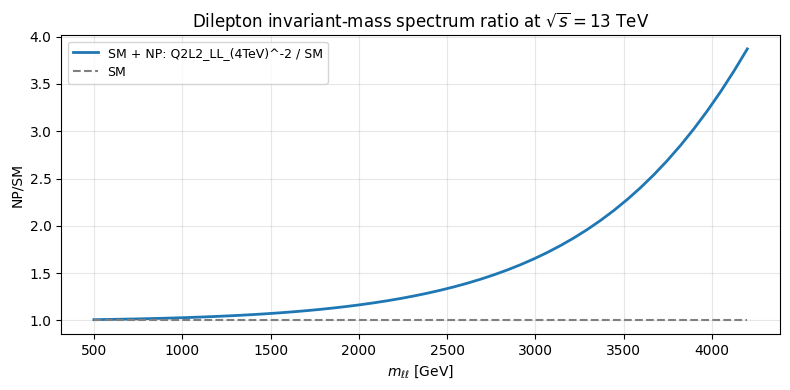

In [125]:
# ---------------------------------
# Choose benchmark and mass grid
# ---------------------------------
#bench_name = "Q1L2_triplet_(30TeV)^-2"   # change as needed
bench_name = "Q2L2_LL_(4TeV)^-2"   # change as needed
eps_np = benchmarks[bench_name]
eps_sm = benchmarks["SM"]

m_grid = np.linspace(500.0, 4200.0, 50)  # GeV

# ---------------------------------
# Compute spectra
# ---------------------------------
ds_dm_sm = np.array([dsigma_dm(m, eps_sm) for m in m_grid])
ds_dm_np = np.array([dsigma_dm(m, eps_np) for m in m_grid])

## ---------------------------------
## Plot dσ/dm
## ---------------------------------
#fig, ax = plt.subplots(figsize=(8,4))
#ax.plot(m_grid, ds_dm_sm, label="SM", linewidth=2)
#ax.plot(m_grid, ds_dm_np, label=f"SM + NP: {bench_name}", linewidth=2)

#ax.set_yscale("log")
#ax.set_xlabel(r"$m_{\ell\ell}$ [GeV]")
#ax.set_ylabel(r"$d\sigma/dm_{\ell\ell}$ [pb/GeV]")
#ax.set_title(r"Dilepton invariant-mass spectrum at $\sqrt{s}=13$ TeV")
#ax.grid(True, alpha=0.3)
#ax.legend(fontsize=9)
#fig.tight_layout()
#plt.show()

# Now, also plot ratio
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(m_grid, ds_dm_np/ds_dm_sm, label=f"SM + NP: {bench_name} / SM", linewidth=2)
ax.hlines(1.0, m_grid[0], m_grid[-1], colors='gray', linestyles='dashed', label="SM")

ax.set_yscale("linear")
ax.set_xlabel(r"$m_{\ell\ell}$ [GeV]")
#ax.set_ylabel(r"$\frac{d\sigma/dm_{\ell\ell}}{d\sigma/dm_{\ell\ell}^{\text{SM}}}$")
ax.set_ylabel(r"NP/SM")
ax.set_title(r"Dilepton invariant-mass spectrum ratio at $\sqrt{s}=13$ TeV")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)
fig.tight_layout()

In [126]:
# Integrate the SM cross section
def integrate_sm_cross_section(eps_sm, m_min, m_max):
    """
    Integrate the SM differential cross section dsigma/dm  over a given mass range.
    """
    return integrate.quad(lambda m: dsigma_dm(m, eps_sm), m_min, m_max)[0]

# Result
# MG reference 0.08 pb, using the defaul PDF set
integrate_sm_cross_section(eps_sm, 500.0, 4000.0)
print("SM cross section (500 GeV - 4 TeV):", integrate_sm_cross_section(eps_sm, 500.0, 4000.0))

/var/folders/1g/4z5z3hss3vb9sxbfj20j8wjw0000gn/T/ipykernel_19924/2375499719.py:6: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(lambda m: dsigma_dm(m, eps_sm), m_min, m_max)[0]


SM cross section (500 GeV - 4 TeV): 0.09446990041838663



## 7. Spectra and LFU ratio $R_{\mu\mu/ee}(m)$ (paper Eq. (5))
$$
R_{\mu\mu/ee}(m)=\frac{d\sigma(pp\to \mu^+\mu^-)/dm}{d\sigma(pp\to e^+e^-)/dm}.
$$


In [127]:

def spectrum(m_grid, eps_mu_by_flavour, eps_e_by_flavour=None):
    if eps_e_by_flavour is None:
        eps_e_by_flavour = {}
    dsmu = np.array([dsigma_dm(m, eps_mu_by_flavour) for m in m_grid])
    dse  = np.array([dsigma_dm(m, eps_e_by_flavour) for m in m_grid])
    return dsmu, dse

m_grid = np.linspace(500, 4000, 60)  # GeV

spectra = {}
for name, eps_mu in benchmarks.items():
    dsmu, dse = spectrum(m_grid, eps_mu, {})  # electrons SM
    spectra[name] = dict(dsmu=dsmu, dse=dse, R=dsmu/(dse + 1e-30))

spectra["SM"]["R"][:5]


array([1., 1., 1., 1., 1.])

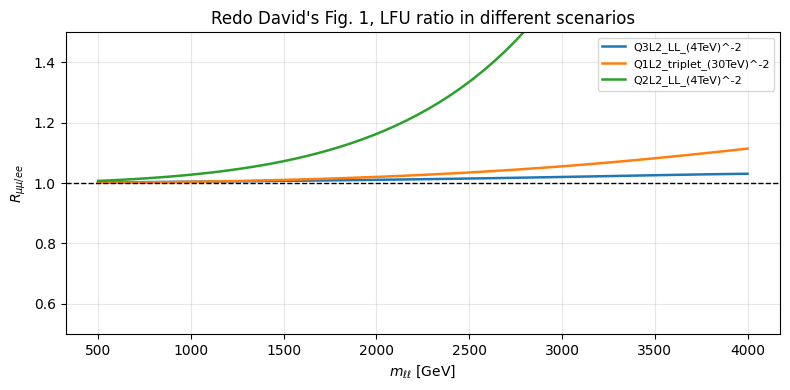

In [130]:
fig, ax = plt.subplots(figsize=(8,4))
for name, out in spectra.items():
    if name == "SM":
        continue
    ax.plot(m_grid, out["R"], label=name, linewidth=1.8)

ax.axhline(1.0, linestyle="--", color="k", linewidth=1)
ax.set_xlabel(r"$m_{\ell\ell}$ [GeV]")
ax.set_ylabel(r"$R_{\mu\mu/ee}$")
ax.set_title(r"Redo David's Fig. 1, LFU ratio in different scenarios")
ax.set_ylim(0.5, 1.5)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)
fig.tight_layout()
plt.show()


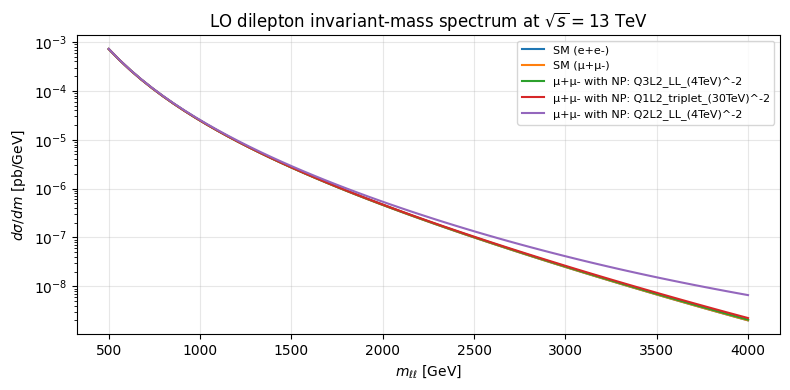

In [14]:

plt.figure(figsize=(8,4))
plt.plot(m_grid, spectra["SM"]["dse"], label="SM (e+e-)")
plt.plot(m_grid, spectra["SM"]["dsmu"], label="SM (μ+μ-)")
for name, out in spectra.items():
    if name == "SM":
        continue
    plt.plot(m_grid, out["dsmu"], label=f"μ+μ- with NP: {name}")
plt.yscale("log")
plt.xlabel(r"$m_{\ell\ell}$ [GeV]")
plt.ylabel(r"$d\sigma/dm$ [pb/GeV]")
plt.title(r"LO dilepton invariant-mass spectrum at $\sqrt{s}=13$ TeV")
plt.grid(True, alpha=0.3)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


In [19]:
np.allclose(spectra["SM"]["dse"], spectra["SM"]["dsmu"])

True


## 8. Bin-integrated ratio as in paper Eq. (8)
The paper rescales ATLAS SM bin counts by a NP/SM ratio built from $\tau L_{q\bar q}(\tau)|F|^2$ integrals.

Below is a helper to compute this **bin ratio** for muons.


In [11]:

def bin_ratio_np_over_sm(mmin, mmax, eps_mu_by_flavour, muF=None):
    if muF is None:
        muF = 0.5*(mmin+mmax)

    tau_min = (mmin**2)/s0
    tau_max = (mmax**2)/s0

    def integ(tau, eps_dict, Qq, gL, gR):
        shat = tau*s0
        FLL = F_form_factor(shat, Qq, Q_e, gL, gZlL, eps_dict.get(("qL","lL"),0.0))
        FLR = F_form_factor(shat, Qq, Q_e, gL, gZlR, eps_dict.get(("qL","lR"),0.0))
        FRL = F_form_factor(shat, Qq, Q_e, gR, gZlL, eps_dict.get(("qR","lL"),0.0))
        FRR = F_form_factor(shat, Qq, Q_e, gR, gZlR, eps_dict.get(("qR","lR"),0.0))
        return abs(FLL)**2 + abs(FLR)**2 + abs(FRL)**2 + abs(FRR)**2

    def numerator():
        tot = 0.0
        for qname, qinfo in quarks.items():
            pid = qinfo["pid"]
            Qq = qinfo["Q"]; gL=qinfo["gL"]; gR=qinfo["gR"]
            eps_dict = eps_mu_by_flavour.get(qname, {})
            def integrand(tau):
                L = luminosity_qqbar(pdf, pid, tau, muF)
                ch = integ(tau, eps_dict, Qq, gL, gR)
                return tau * L * ch
            tot += integrate.quad(integrand, tau_min, tau_max, epsabs=0, epsrel=2e-3, limit=200)[0]
        return tot

    def denominator():
        tot = 0.0
        for qname, qinfo in quarks.items():
            pid = qinfo["pid"]
            Qq = qinfo["Q"]; gL=qinfo["gL"]; gR=qinfo["gR"]
            def integrand(tau):
                L = luminosity_qqbar(pdf, pid, tau, muF)
                ch = integ(tau, {}, Qq, gL, gR)
                return tau * L * ch
            tot += integrate.quad(integrand, tau_min, tau_max, epsabs=0, epsrel=2e-3, limit=200)[0]
        return tot

    num = numerator()
    den = denominator()
    return float(num/den)

bin_ratio_np_over_sm(1000, 1200, benchmarks["Q1L2_triplet_(30TeV)^-2"])


1.005218897246984


## 9. Notes for *quantitative* agreement with the paper
To match the paper’s plots/limits quantitatively:
1. Install **LHAPDF** and the **same PDF set** (paper uses an MMHT2014 NNLO set).
2. Use ATLAS **reconstructed-mass binning** and acceptance (their fit is to post-selection bins).
3. Map operator choices precisely (triplet vs singlet): \(C_{D(U)} \propto c^{(1)} \pm c^{(3)}\).
4. (Optional) Apply a K-factor if you want absolute normalisation beyond LO.
